###**0. Imports e connect à Google Drive**

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# este comando é usado para mudar a diretória atual para o dataset
%cd /content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset


##**Primeiro passo:** Extrair os ficheiros .png para entrarem no modelo, i.e., criar X_train e X_val

In [8]:
def number_of_images(X_type):

    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_regression'
    files = os.listdir(root)

    return len(files)

In [9]:
# acessar às imagens e bboxes guardadas na drive, criadas a partir de outro código
# normalizando-as

def create_X_set_normalized(X_type):

    X_set = []
    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_regression'
    length = number_of_images(X_type)

    for i in range(0, length):

      try:
        path = root + '/processed_' + X_type + 'image_' + str(i) + '.png'   # se calhar é melhor usar os.path.dir nestas situações e outras
        arr3 = cv2.imread(path)
        img_arr, _, _ = cv2.split(arr3)
        img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)   # é preciso normalizar de novo
        X_set.append(img_normalized)

      except ValueError:
        pass

    return np.array(X_set)

In [10]:
X_train = create_X_set_normalized('train')
X_val = create_X_set_normalized('valid')

In [11]:
X_train.shape, X_val.shape

((2071, 384, 512), (66, 384, 512))

##**Segundo passo:** Extrair as coordenadas das bounding boxes diretamente dos ficheiros csv, i.e., criar y_train e y_val

In [12]:
df_ytrain = pd.read_csv('./organized_data_gray/train/y_train_regression.csv')
df_yval = pd.read_csv('./organized_data_gray/valid/y_val_regression.csv')

In [13]:
def y_set(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [14]:
y_train = y_set(df_ytrain)
y_val = y_set(df_yval)

y_train[:2], y_val[:2]  # estes estão organizados devidamente, mas o X_train e X_val não estão

(array([[0.55348608, 0.67904656, 0.07315046, 0.0631929 ],
        [0.77792498, 0.5537694 , 0.13965087, 0.13414634]]),
 array([[0.70560578, 0.91962306, 0.08977556, 0.08536585],
        [0.95207294, 0.3248337 , 0.02743142, 0.03547672]]))

In [15]:
y_train.shape, y_val.shape

((2071, 4), (66, 4))

--- **Apenas a verificar se está a construir a bounding box corretamente** ---

In [16]:
# esta função também pode servir para mostrar uma imagem sem bounding box, basta colocar bbox = []

def show_image_bbox(X_arr, y_arr, new_img_path):

  y_arr_albu = [0,0,0,0]

  if len(y_arr) != 0:
    y_arr_albu[0] = y_arr[0] - y_arr[2] / 2
    y_arr_albu[1] = y_arr[1] - y_arr[3] / 2
    y_arr_albu[2] = y_arr[2] + y_arr_albu[0]
    y_arr_albu[3] = y_arr[3] + y_arr_albu[1]


  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  X_arr = cv2.merge([X_arr, X_arr, X_arr])   # para conseguir visualizar uma imagem a cinzento

  bbox_ = copy.deepcopy(y_arr_albu)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

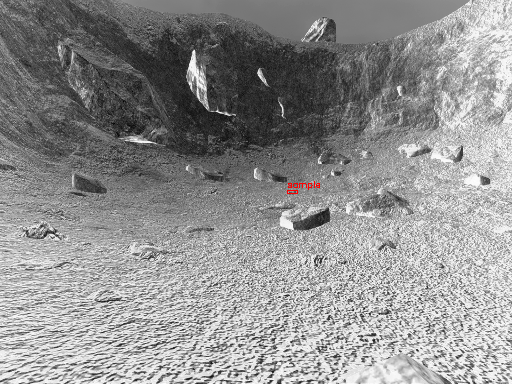

In [17]:
index = 900
show_image_bbox(X_train[index], y_train[index], 'new_dataset.png')

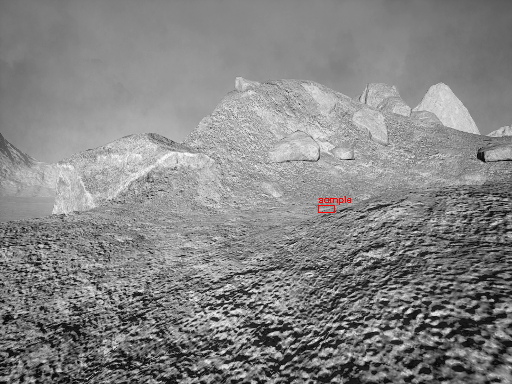

In [18]:
index = 60
show_image_bbox(X_val[index], y_val[index], 'new_dataset.png')

##**Terceiro passo:** Obter uma imagem aleatoria de X_test e y_test

In [19]:
len(os.listdir('./organized_data_gray/test/X_test_images'))

2884

In [20]:
# esta função vai apenas buscar uma imagem de cada vez ao conjunto de teste,
# porque não dava para guardar 3000 imagens numa variável e correr
# o modelo sem problemas com a RAM

def choose_or_randomize_testimage(choice):

    length = len(os.listdir('./organized_data_gray/test/X_test_images'))
    root = './organized_data_gray/test/X_test_images'

    if choice == 'random':
      number = random.choice(list(range(0, length)))

    else:
      number = choice

    # buscar a imagem
    path = root + '/processed_testimage_' + str(number) + '.png'
    arr3 = cv2.imread(path)
    img_arr, _, _ = cv2.split(arr3)
    img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # buscar a bounding box
    df_ytest = pd.read_csv('./organized_data_gray/test/y_test.csv')
    y = []

    for j in range(0, df_ytest.shape[1]):
      y.append(df_ytest.iloc[number, j])

    X_testimage = np.array(img_normalized)
    y_testbbox = np.array(y)

    return X_testimage, y_testbbox

In [21]:
choice = 'random'
test_image, ground_truth_bbox = choose_or_randomize_testimage(choice)

try:
  show_image_bbox(test_image, ground_truth_bbox, 'imagetest.png')
  print('There is a sample in this image')
except ValueError:
  print('There is no sample in this image')

There is a sample in this image


In [22]:
# usar esta célula caso a anterior tenha tido um output positivo
#show_image_bbox(test_image, ground_truth_bbox, 'imagetest.png')

##**Quarto passo:** Callbacks: ModelCheckpoint, CSVLogger, TensorBoard

In [23]:
!mkdir callbacks
!mkdir ./callbacks/tensorboard
!mkdir ./callbacks/checkpoints

mkdir: cannot create directory ‘callbacks’: File exists
mkdir: cannot create directory ‘./callbacks/tensorboard’: File exists
mkdir: cannot create directory ‘./callbacks/checkpoints’: File exists


In [24]:
# preparar o CSVLogger callback object

logger_path = './callbacks/graytraining_logger' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S') + '.log'  # tem gray na path do file para diferenciar
csv_logger = CSVLogger(logger_path,
                       append=True,
                       separator=',')

In [25]:
# preparar o ModelCheckpoint callback object

checkpoint_path = './callbacks/checkpoints/grayCkpt1_{epoch:02d}_{val_loss:.05f}_.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [26]:
# preparar o TensorBoard callback object

%load_ext tensorboard

tboard_path = './callbacks/tensorboard/gray_' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard = TensorBoard(log_dir = tboard_path,
                          histogram_freq=1)

## **Quinto passo**: Construir e avaliar o modelo

###**Arquitetura do modelo**

In [27]:
X_train.shape

(2071, 384, 512)

In [28]:
_, height, width = X_train.shape
model = Sequential([

    Conv2D(filters=16,kernel_size=(3,3), input_shape = (height, width, 1), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),

    Dense(4, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 191, 255, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 94, 126, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 94, 126, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 124, 64)       1

In [36]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [72]:
model.fit(X_train,
          y_train,
          epochs = 30,
          batch_size = 10,
          validation_data = (X_val, y_val),
          callbacks = [checkpoint, csv_logger, tensorboard])

Epoch 1/10
139/139 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.8928
Epoch 1: val_loss improved from inf to 0.00665, saving model to ./callbacks/checkpoints/grayCkpt1_01_0.00665_.h5
139/139 [==============================] - 427s 3s/step - loss: 0.0032 - accuracy: 0.8928 - val_loss: 0.0067 - val_accuracy: 0.6364
Epoch 2/10
139/139 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9097
Epoch 2: val_loss improved from 0.00665 to 0.00649, saving model to ./callbacks/checkpoints/grayCkpt1_02_0.00649_.h5
139/139 [==============================] - 428s 3s/step - loss: 0.0031 - accuracy: 0.9097 - val_loss: 0.0065 - val_accuracy: 0.6667
Epoch 3/10
139/139 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9126
Epoch 3: val_loss did not improve from 0.00649
139/139 [==============================] - 432s 3s/step - loss: 0.0032 - accuracy: 0.9126 - val_loss: 0.0070 - val_accuracy: 0.6515
Epoch 4/10
139/139 [===================

In [29]:
model.load_weights('./callbacks/checkpoints/grayCkpt1_17_0.00889_.h5')

###**Predictions:**

In [34]:
# predictions com X_val
y_pred = model.predict(X_val)
y_pred[:5]

3/3 [==============================] - 3s 488ms/step


array([[0.56150115, 0.6435188 , 0.07621016, 0.05507098],
       [0.6681017 , 0.42875725, 0.12686661, 0.10513824],
       [0.6419634 , 0.4074356 , 0.11885064, 0.06552798],
       [0.58034116, 0.2542485 , 0.09370393, 0.04539542],
       [0.6396002 , 0.15083945, 0.04707336, 0.02194743]], dtype=float32)

In [ ]:
%tensorboard --logdir=./callbacks/tensorboard

**Checking Random examples of where the model is predicting the bounding boxes for X_val and X_train, respectively**

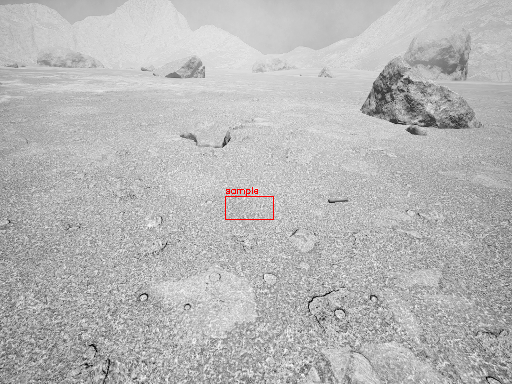

In [94]:
index = 65
show_image_bbox(X_val[index], y_pred[index], 'transformed.png')

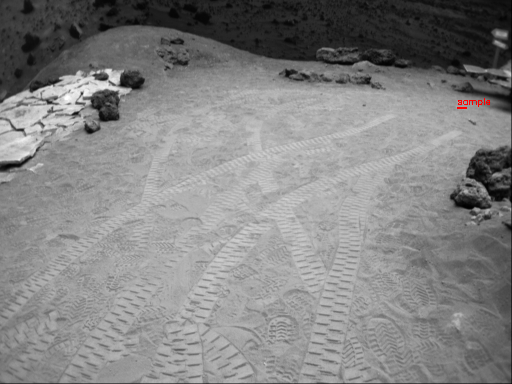

In [64]:
index = 17
show_image_bbox(X_train[index], y_pred_train[index], 'transformed.png')

###**Métricas:** Intersection over union (IoU)

**Intersection over union: metrica usada para medir a accuracy da localização**

In [30]:
# esta função executa o contrário da anterior: transforma uma bounding box com
# coordenadas em formato YOLO para uma bounding box em formato Albu

def bboxYOLO_to_Albu(y_set):

    y_Albu = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = bbox[0] - bbox[2] / 2
        vector[1] = bbox[1] - bbox[3] / 2
        vector[2] = bbox[2] + vector[0]
        vector[3] = bbox[3] + vector[1]

        y_Albu.append(vector)

    return np.array(y_Albu)

In [31]:
def intersection_over_union(bboxA, bboxB):

    bboxes = bboxYOLO_to_Albu([bboxA, bboxB])
    bbox1 = bboxes[0]
    bbox2 = bboxes[1]

    # bbox = [xmin, ymin, xmax, ymax]
    xmin = max(bbox1[0], bbox2[0])
    ymin = max(bbox1[1], bbox2[1])
    xmax = min(bbox1[2], bbox2[2])
    ymax = min(bbox1[3], bbox2[3])

    intersection_width = xmax - xmin
    intersection_height = ymax - ymin

    if intersection_width <= 0 or intersection_height <= 0:
      return 0

    intersection_area = intersection_width * intersection_height

    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = bbox1_area + bbox2_area - intersection_area

    IoU = round(intersection_area / union_area, 2)  # arredonda a 2 casas decimais

    return IoU

In [36]:
# uma função que pode dar informações rápidas e talvez relevantes sobre a IoU

def iou_info(y_set, y_pred):

  iou_sum = 0
  iou_above_threshold = []

  threshold = 0

  for i in range(len(y_set)):
      iou = intersection_over_union(y_set[i], y_pred[i])

      if iou > 0:
        iou_above_threshold.append(i)
        iou_sum += iou

  pct_iou_mean = iou_sum / len(iou_above_threshold) * 100
  pct_intersection = len(iou_above_threshold) / y_set.shape[0] * 100

  return pct_iou_mean, len(iou_above_threshold), pct_intersection, iou_above_threshold

In [37]:
print(' - for y_val and y_pred:'
      '\n mean % of the area intersected in all intersections:', iou_info(y_val, y_pred)[0],
      '\n number of intersections:', iou_info(y_val, y_pred)[1],
      '\n percentage of intersections:', iou_info(y_val, y_pred)[2],
      '\n indexes of images with (good) intersections:', iou_info(y_val, y_pred)[3])

 - for y_val and y_pred:
 mean % of the area intersected in all (good) intersections: 4.0 
 number of (good) intersections: 6 
 percentage of (good) intersections: 9.090909090909092 
 indexes of images with (good) intersections: [13, 17, 24, 32, 36, 42]


In [57]:
# predictions com X_train
y_pred_train = model.predict(X_train)
print(' - for y_train and y_pred_train:'
      '\n mean % of the area intersected in all (good) intersections:', iou_info(y_train, y_pred_train)[0],
      '\n number of (good) intersections:', iou_info(y_train, y_pred_train)[1],
      '\n percentage of (good) intersections:', iou_info(y_train, y_pred_train)[2],
      '\n indexes of images with (good) intersections:', iou_info(y_train, y_pred_train)[3])

 - for y_train and y_pred_train:
 mean % of the area intersected in all (good) intersections: 12.634686346863486 
 number of (good) intersections: 542 
 percentage of (good) intersections: 26.170931916948337 
 indexes of images with (good) intersections: [2, 4, 6, 18, 20, 24, 25, 28, 32, 36, 38, 44, 45, 46, 47, 56, 58, 59, 63, 64, 65, 76, 82, 86, 88, 90, 91, 94, 95, 105, 111, 116, 117, 124, 127, 131, 136, 139, 140, 145, 146, 158, 159, 160, 165, 167, 168, 177, 183, 191, 198, 200, 201, 205, 207, 211, 214, 218, 224, 229, 230, 238, 244, 245, 248, 252, 253, 258, 263, 264, 272, 273, 279, 287, 288, 289, 294, 298, 306, 309, 310, 312, 313, 316, 326, 339, 340, 341, 343, 350, 352, 357, 360, 362, 363, 379, 380, 385, 386, 389, 392, 396, 403, 404, 417, 425, 426, 440, 449, 452, 453, 454, 467, 471, 472, 475, 477, 478, 479, 482, 491, 495, 504, 512, 515, 519, 521, 522, 524, 527, 536, 541, 543, 548, 549, 550, 554, 556, 558, 562, 573, 578, 583, 590, 591, 593, 594, 595, 605, 607, 609, 611, 614, 615, 616, 6